# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
* Idea

# Libraries

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import argparse

import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize
import Nets.tools as tools


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Parser

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, required=False, default=None)
parser.add_argument('--data', type=str, required=False, default=None)

parser.add_argument('--bs', type=int, required=False, default=None)
parser.add_argument('--idx', type=int, required=False, default=None)
parser.add_argument('--epoch', type=int, required=False, default=None)
parser.add_argument('--noise', type=float, required=False, default=None)

parser.add_argument('--train_model', action='store_true', default=False)
parser.add_argument('--cache', action='store_true', default=False)
parser.add_argument('--save', action='store_true', default=False)
parser.add_argument('--sigmoid', action='store_true', default=False)
parser.add_argument('--focal', action='store_true', default=False)

parser.add_argument('--beta_upper', type=float, required=False, default=None)
parser.add_argument('--gamma', type=float, required=False, default=None)
parser.add_argument('--alpha', type=float, required=False, default=None)

file_name = None
try:
    file_name = __file__
except:
    print("Jupyter Notebook")
       
if file_name is None:
    args = parser.parse_args("")
    args.train_model = False
    args.cache = True
    #args.save = True
    args.save = True
    args.sigmoid = False
    args.focal = True
else:    
    args = parser.parse_args()

Jupyter Notebook


# Options

In [3]:
# Generall Parameters
MODEL= 'SGED_FOCAL_LOSS_0.5_g2_a2' if args.model is None else args.model
DATA= 'SceneNetFloorTiledTextureRandom' if args.data is None else args.data
TRAIN_DS ='Train'
TEST_DS = 'Test'
HALF = True

# Dataset Loading Parameters
IMG_SIZE_HEIGHT = 1280
IMG_SIZE_WIDTH = 720
NUM_CLASSES = 3
MAX_IMG_TRAIN = 1500
MAX_IMG_TEST = 300
SEED = None
BATCH_SIZE = 3 if args.bs is None else args.bs
CACHE = args.cache
NOISE_STD = 0.0 if args.noise is None else args.noise

# Model Parameters
BACKBONE = "MobileNetV2"
output = 5
BACKBONE_OUTPUT = [1,2,3,output]
BACKBONE_WEIGHTS = "imagenet"
ALPHA = 0.35
FINE_TUNING = False
FINE_TUNE_EPOCHS = 10
TRAINABLE_IDX = 0 if args.idx is None else args.idx # (3-1), as indexing starts at 0
EPOCHS = 80 if args.epoch is None else args.epoch
SAVE = args.save
TRAIN_MODEL = args.train_model

#Model Callback
MODEL_SAVE_EPOCH_FREQ = 5
DEL_OLD_CHECKPOINTS = False
TENSORBOARD = False
DEL_OLD_TENSORBOARD = True

# LOSS
weighted_multi_label_sigmoid_edge_loss = args.sigmoid
focal_loss = args.focal

beta_upper = 0.5 if args.beta_upper is None else args.beta_upper
beta_lower = 1.0 - beta_upper
gamma=2.0 if args.gamma is None else args.gamma 
alpha=2.0 if args.alpha is None else args.alpha
class_weighted = True
weighted_beta=True


# All Pixels have been labeled correctly and thus we don't need to account shifted labels 
# and a protection band around the labels for the calculation of the metrics

# In the work of Frey he mentioned that state of the Art ? is 2% of diagonal. 
# He takes 1%, I sugest to take a threshold of 3 Pixels. 
#I don't think that I made more then 3 Pixel mistake in labeling and tracking. Thus this is 0.4%
THRESHOLD_EDGE_WIDTH_REAL = 2

# Data Augmentation:
aug_param = {"contrast_factor": 0.9, "brightness": 0.1, "hue": 0.03, "saturation": 0.9, "gaussian_value": 0.015,
            "value": 0.1, "strength_spot": 0.3, "blur": False, "sigma": 1.0}

#TESTING
test = False
if test:
    EPOCHS = 10
    MAX_IMG_TRAIN = 18
    MAX_IMG_TEST = 3

# Load Dataset, Preprocess Images and Dataset

In [4]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS, make_dirs=True)

data_processing.clean_model_directories(paths, DEL_OLD_CHECKPOINTS, DEL_OLD_TENSORBOARD)

if TRAIN_MODEL:
    
    rng = tf.random.Generator.from_seed(123, alg='philox')


    train_ds, img_count_train = data_processing.load_dataset(paths,"TRAIN", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, 
                                                             MAX_IMG_TRAIN, noise_std=NOISE_STD)
    train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, prefetch=True, 
                                                  img_count=img_count_train, augment=True, rng=rng, aug_param=aug_param)

test_ds, img_count_test = data_processing.load_dataset(paths,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, 
                                                       MAX_IMG_TEST, noise_std=None)
test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, prefetch=True, 
                                             img_count=img_count_test)

The TEST Dataset contains 300 images.


2022-06-07 22:11:05.672508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 22:11:05.681017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 22:11:05.681141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 22:11:05.681830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL, make_dirs=False)

test_real_ds, img_count_test_real = data_processing.load_dataset(paths_real,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)

The TEST Dataset contains 25 images.


# Model

In [6]:
if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred : losses.weighted_multi_label_sigmoid_loss(y_true,y_pred,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred : losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")

In [7]:
if TRAIN_MODEL:

    if HALF:
        output_dims = (int(IMG_SIZE_HEIGHT/2), int(IMG_SIZE_WIDTH/2))
    else:
        output_dims = (IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)

    # BACKBONE
    backbone, output_names = backbones.get_backbone(name=BACKBONE,weights=BACKBONE_WEIGHTS,
                                              height=IMG_SIZE_HEIGHT,width=IMG_SIZE_WIDTH,
                                              alpha=ALPHA, output_layer = BACKBONE_OUTPUT, 
                                              trainable_idx=TRAINABLE_IDX)

    # DASPP
    daspp = features.DASPP(backbone.output[-1])

    # Decoder
    decoded = features.decoder(daspp, backbone.output[-1], output_dims=output_dims, NUM_CLASSES=NUM_CLASSES, num_side_filters = 6)


    # SIDE FEATURES
    # TODO: Upsampling: Nearest NEIGHBOUR ?
    upsample_side_1 = features.side_feature_SGED(backbone.output[0], output_dims=output_dims ,interpolation="bilinear", name="side1")
    upsample_side_2 = features.side_feature_SGED(backbone.output[1], output_dims=output_dims ,interpolation="bilinear", name="side2")
    upsample_side_3 = features.side_feature_SGED(backbone.output[2], output_dims=output_dims ,interpolation="bilinear", name="side3")

    # TODO: adaptive weight fusion ?
    # CONCATENATE
    side_outputs = [upsample_side_1,upsample_side_2,upsample_side_3,decoded]
    concat = features.shared_concatenation(side_outputs,NUM_CLASSES)

    # FUSE_CLASSIFICATION
    output = features.fused_classification(concat,NUM_CLASSES,name="output")

    model = tf.keras.Model(inputs = backbone.input, outputs = output)

# Compile and Train Model

In [8]:
if TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir /home/david/SemesterProject/Models/CASENet/logs

In [9]:
if TRAIN_MODEL:
    # learning rate schedule
    base_learning_rate = 0.0015
    end_learning_rate = 0.0005
    decay_step = np.ceil(img_count_train / BATCH_SIZE)*EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

    frequency = int(np.ceil(img_count_train / BATCH_SIZE)*MODEL_SAVE_EPOCH_FREQ)+1

    logdir = os.path.join(paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = paths["CKPT"]+ "/ckpt-loss={val_loss:.2f}-epoch={epoch:.2f}-f1={val_f1:.4f}",
                                                    save_weights_only=False,save_best_only=False,monitor="val_f1",verbose=1,save_freq= 'epoch', period=5),
                tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)]

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

    history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_real_ds, callbacks=callbacks)

In [10]:
model_ckpt = os.listdir(paths['CKPT'])

f1_max = 0
for ckpt_name in model_ckpt:
    if float(ckpt_name[-4:]) > f1_max:
        f1_max = float(ckpt_name[-4:])
        model_path = paths['CKPT']+"/"+ckpt_name
        
        print(model_path)

custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                  "F1Edges": metrics.F1Edges,
                  "<lambda>":loss}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/SGED_FOCAL_LOSS_0.5_g2_a2/CKPT/ckpt-loss=299.66-epoch=45.00-f1=0.4183
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/SGED_FOCAL_LOSS_0.5_g2_a2/CKPT/ckpt-loss=264.14-epoch=50.00-f1=0.4726
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/SGED_FOCAL_LOSS_0.5_g2_a2/CKPT/ckpt-loss=246.89-epoch=75.00-f1=0.5069


# Plot Results

In [11]:
if TRAIN_MODEL:
    plot_losses = ["loss", "output_loss"]
    plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]

    path = os.path.join(paths["FIGURES"],"training.svg")

    visualize.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path)

2022-06-07 22:11:12.700857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


100/100 - 10s - loss: 0.0000e+00 - accuracy_edges: 0.7178 - f1_1: 0.0552 - precision_1: 0.0284 - recall_1: 0.9992 - f1_2: 0.1164 - precision_2: 0.0618 - recall_2: 0.9996 - f1_3: 0.0417 - precision_3: 0.0213 - recall_3: 0.9965 - 10s/epoch - 99ms/step
100/100 - 7s - loss: 0.0000e+00 - accuracy_edges: 0.9521 - f1_1: 0.3230 - precision_1: 0.1929 - recall_1: 0.9919 - f1_2: 0.3633 - precision_2: 0.2221 - recall_2: 0.9960 - f1_3: 0.4329 - precision_3: 0.2784 - recall_3: 0.9729 - 7s/epoch - 66ms/step
100/100 - 7s - loss: 0.0000e+00 - accuracy_edges: 0.9805 - f1_1: 0.5437 - precision_1: 0.3767 - recall_1: 0.9761 - f1_2: 0.5895 - precision_2: 0.4208 - recall_2: 0.9840 - f1_3: 0.6223 - precision_3: 0.4655 - recall_3: 0.9383 - 7s/epoch - 67ms/step
100/100 - 7s - loss: 0.0000e+00 - accuracy_edges: 0.9896 - f1_1: 0.6866 - precision_1: 0.5399 - recall_1: 0.9427 - f1_2: 0.7320 - precision_2: 0.5932 - recall_2: 0.9557 - f1_3: 0.7188 - precision_3: 0.5993 - recall_3: 0.8978 - 7s/epoch - 68ms/step
100/10

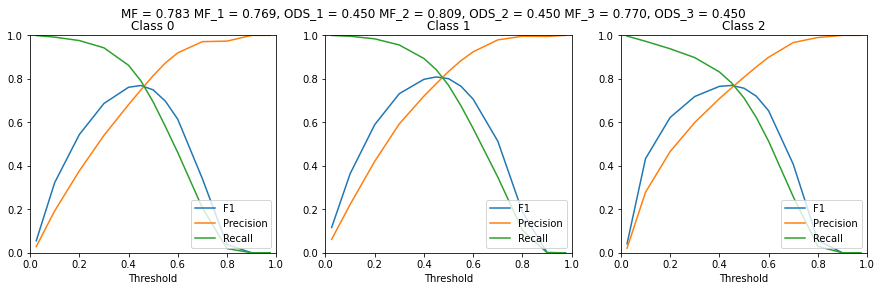

In [12]:
### Maximum F1 Score:
if not TRAIN_MODEL:
    step_width = 0.05
    threshold_range = [0.05,0.95]
    threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)
    threshold_array = np.array([0.025, 0.1, 0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8, 0.9, 0.975])

    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_ds.svg")
    threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, 
                                                                         ds=test_ds,
                                                                         num_classes=NUM_CLASSES,
                                                                         threshold_array=threshold_array, 
                                                                         threshold_edge_width=0, save=SAVE, 
                                                                         path=path_metrics_evaluation_plot)

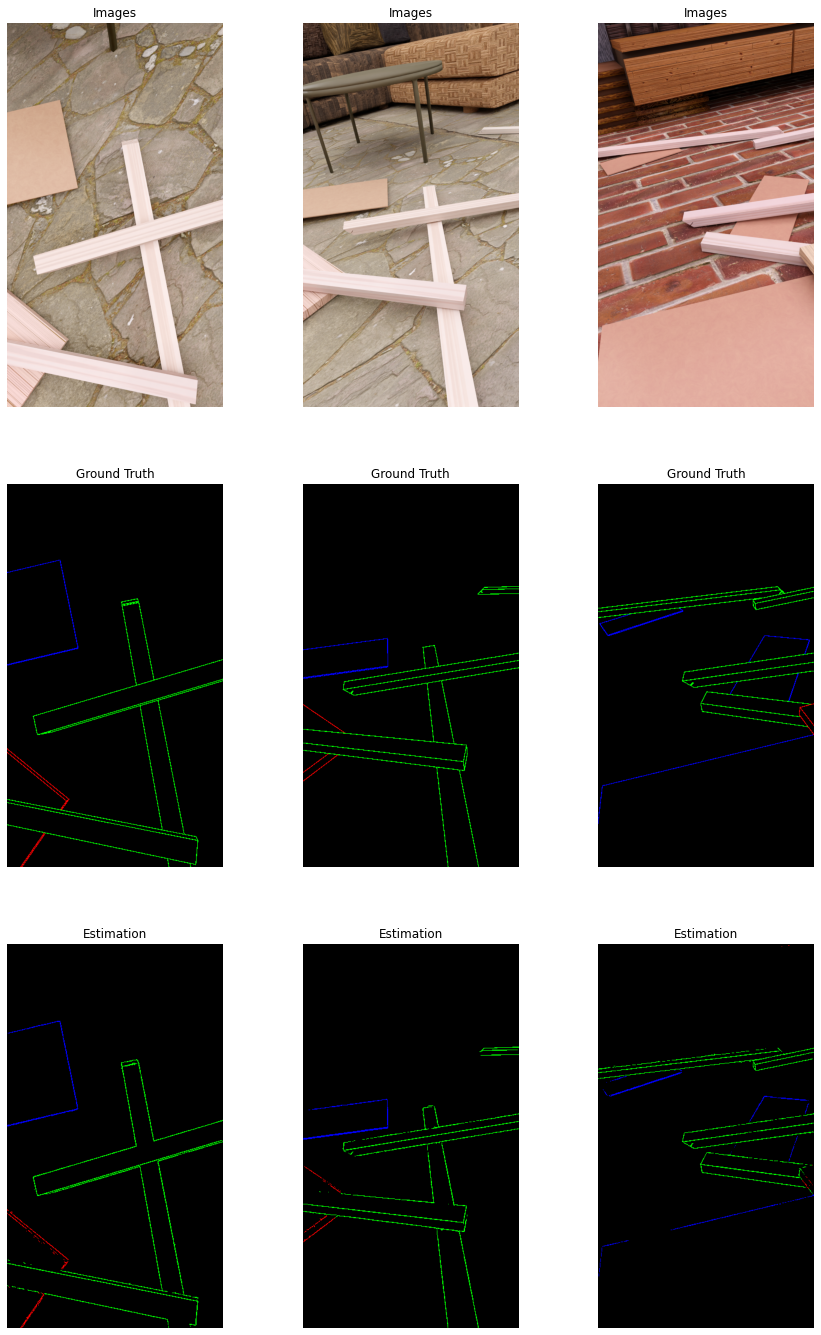

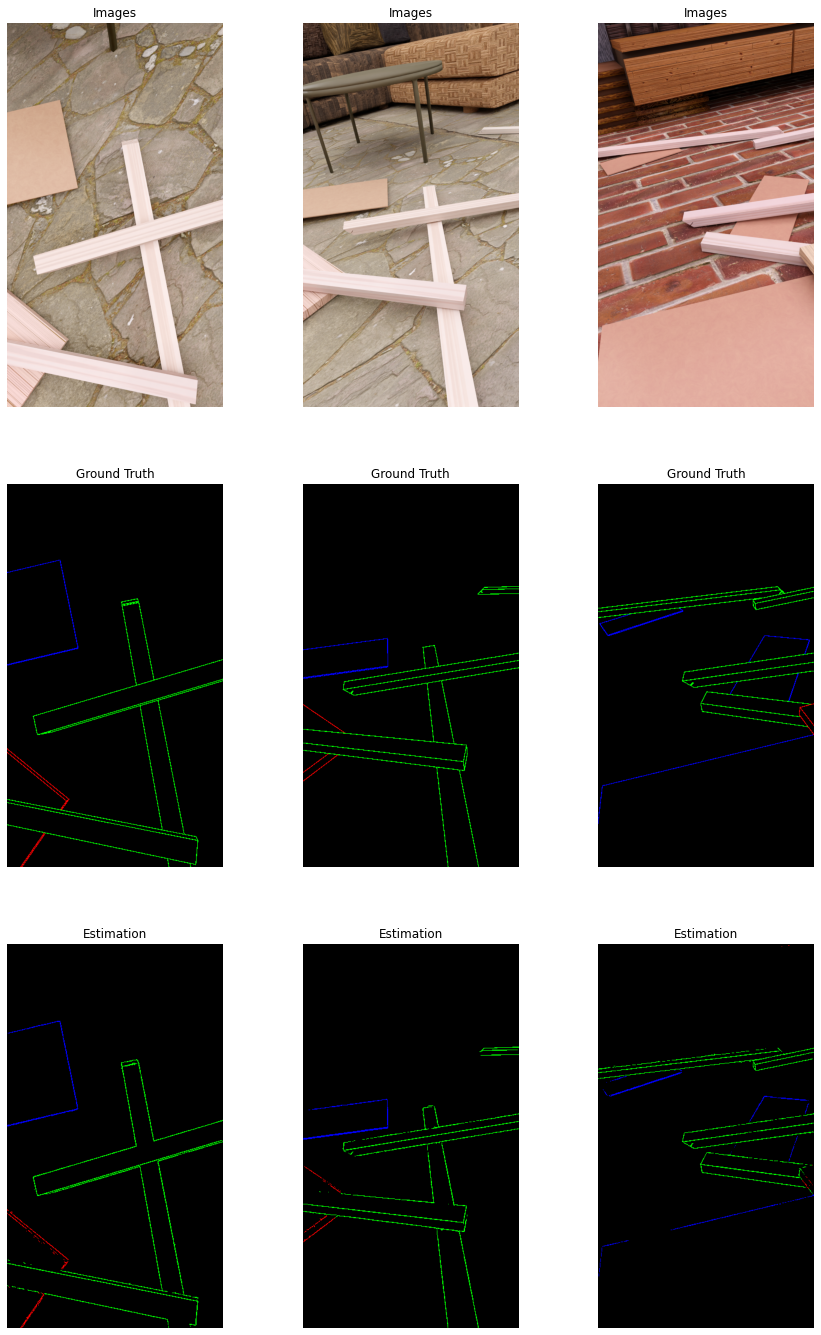

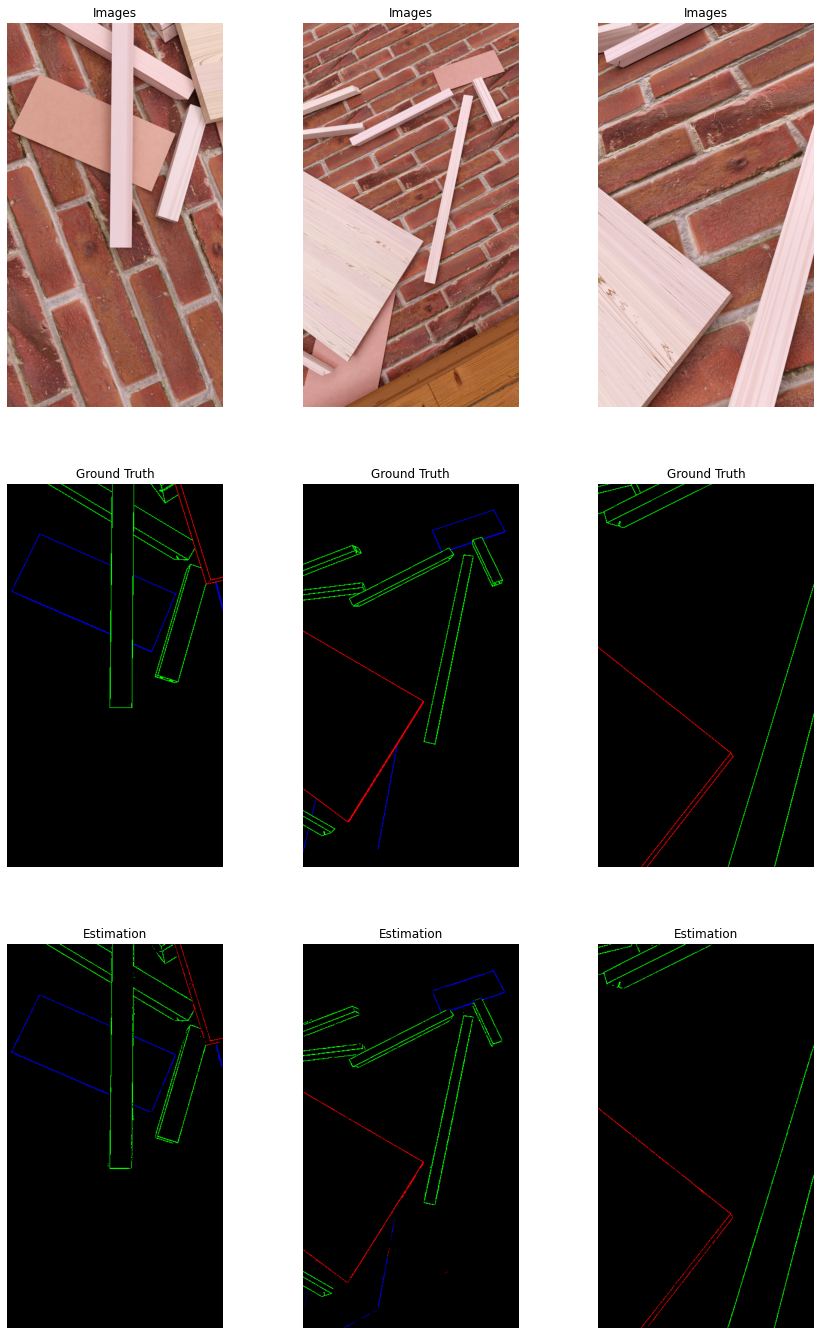

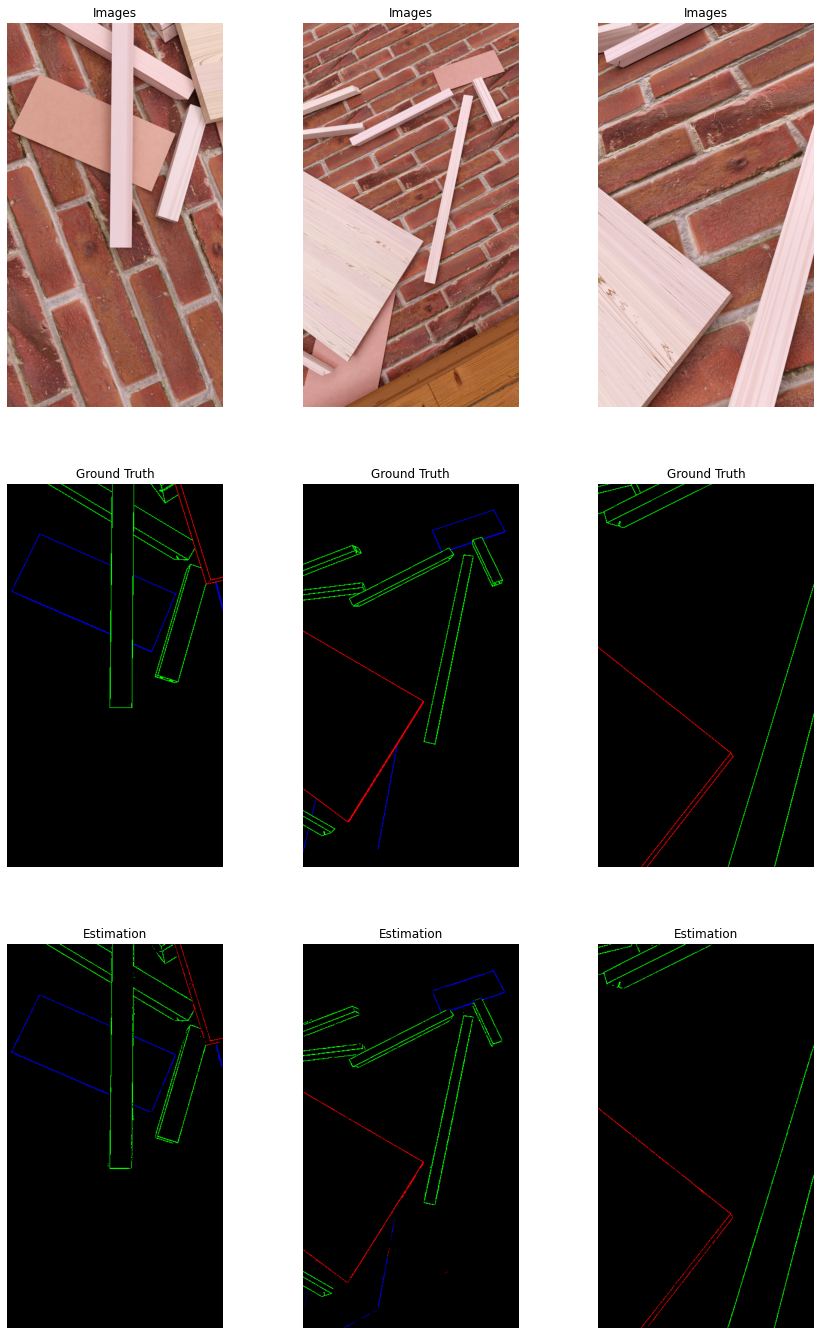

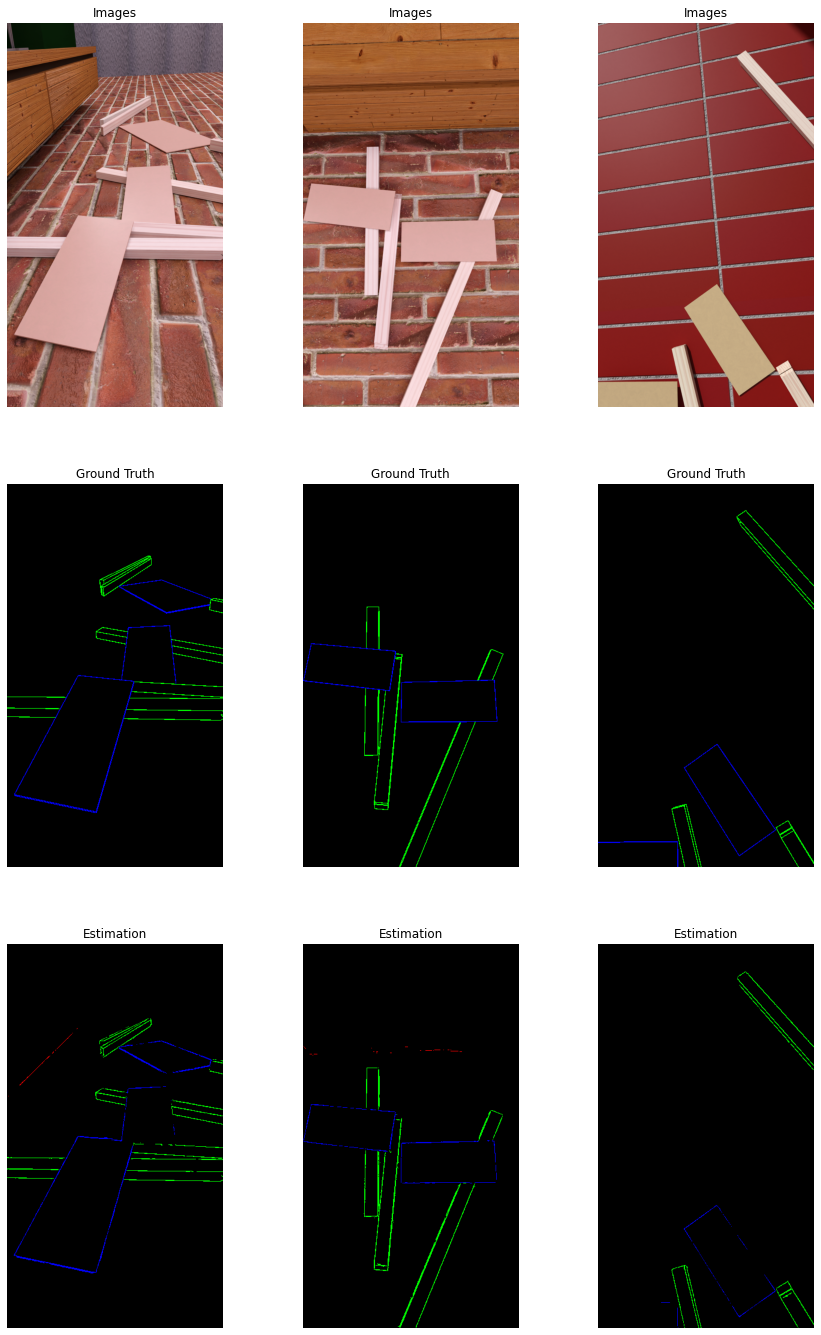

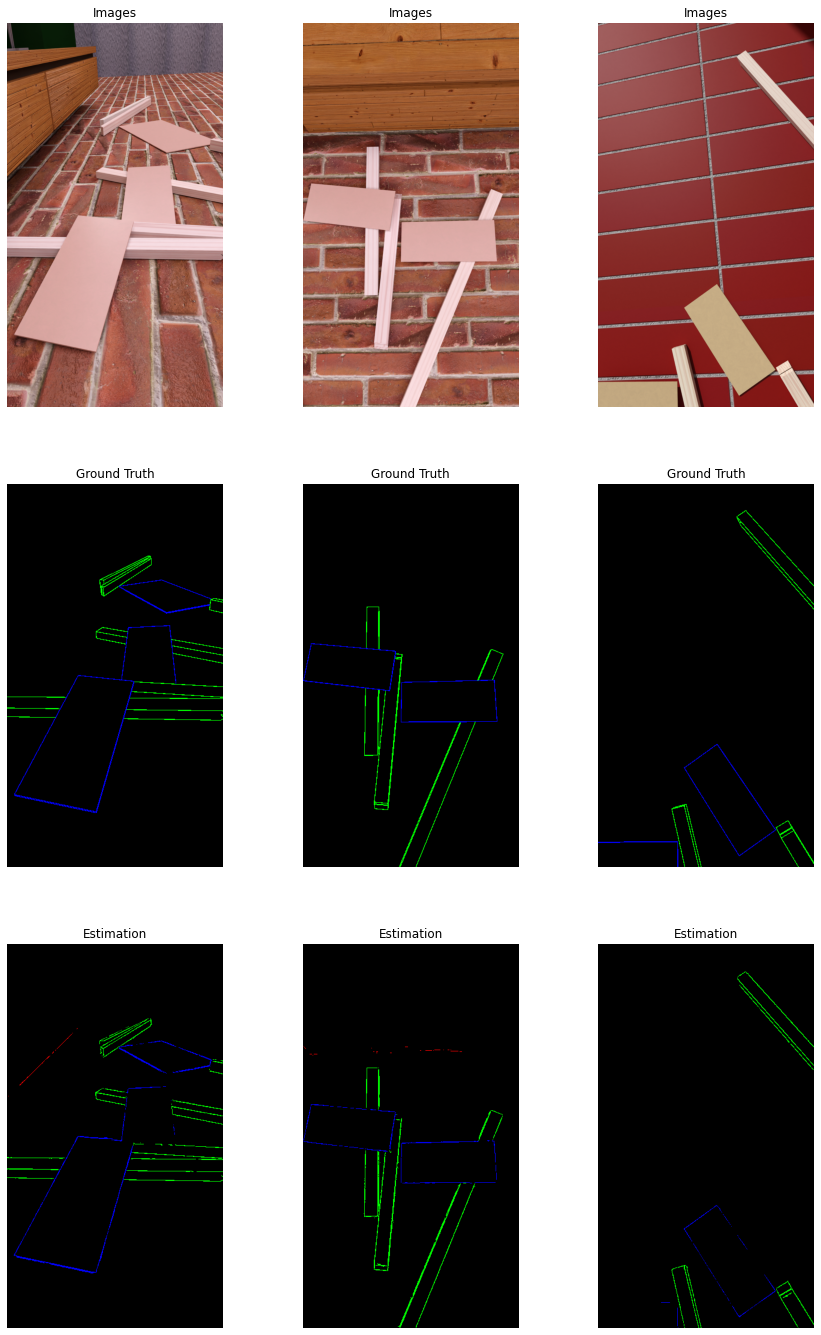

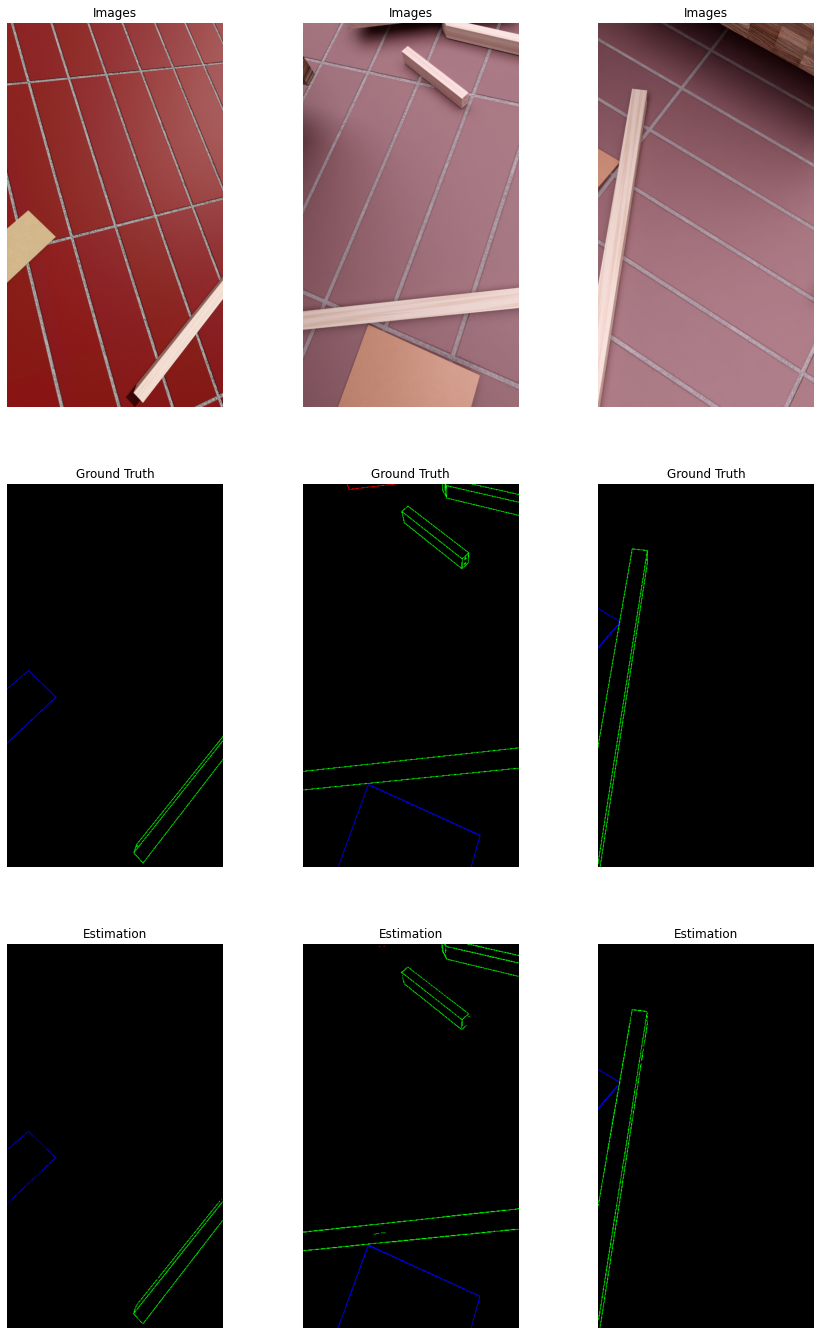

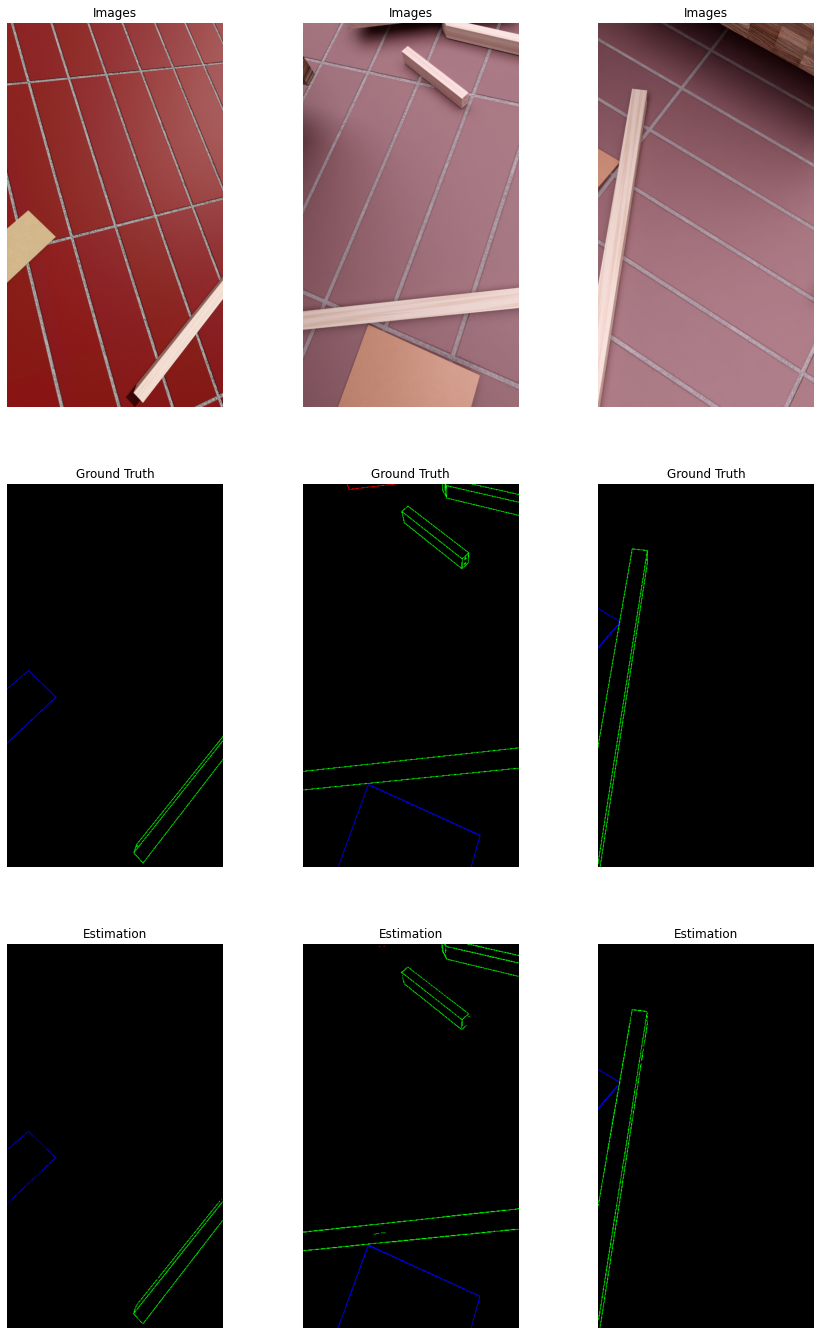

In [13]:
if not TRAIN_MODEL:
    i = 0
    for img, label in test_ds.take(4):
        img, label = img, label

        threshold = 0.5

        predictions = model.predict(img)
        predictions = tools.predict_class_postprocessing(predictions, threshold=threshold)

        path = os.path.join(paths["FIGURES"],"img_test_threshold_{}_{}".format(threshold,i))
        visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

        threshold = threshold_f1_max
        path = os.path.join(paths["FIGURES"],"img_test_ods_{}".format(i))
        visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

        i += 1

# Fine Tuning

# Evaluate on Test DS of Real Images

In [14]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL, make_dirs=False)

test_real_ds, img_count_test_real = data_processing.load_dataset(paths_real,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)


The TEST Dataset contains 25 images.


## Metrics Evaluation

4/4 - 2s - loss: 0.0000e+00 - accuracy_edges: 0.8585 - f1_1: 0.0234 - precision_1: 0.0118 - recall_1: 0.9971 - f1_2: 0.0402 - precision_2: 0.0205 - recall_2: 0.9990 - f1_3: 0.0504 - precision_3: 0.0259 - recall_3: 0.9790 - 2s/epoch - 571ms/step
4/4 - 2s - loss: 0.0000e+00 - accuracy_edges: 0.9442 - f1_1: 0.0705 - precision_1: 0.0366 - recall_1: 0.9863 - f1_2: 0.0919 - precision_2: 0.0482 - recall_2: 0.9930 - f1_3: 0.1874 - precision_3: 0.1041 - recall_3: 0.9395 - 2s/epoch - 379ms/step
4/4 - 1s - loss: 0.0000e+00 - accuracy_edges: 0.9674 - f1_1: 0.1238 - precision_1: 0.0661 - recall_1: 0.9682 - f1_2: 0.1529 - precision_2: 0.0829 - recall_2: 0.9801 - f1_3: 0.2992 - precision_3: 0.1797 - recall_3: 0.8927 - 1s/epoch - 281ms/step
4/4 - 1s - loss: 0.0000e+00 - accuracy_edges: 0.9777 - f1_1: 0.1638 - precision_1: 0.0896 - recall_1: 0.9452 - f1_2: 0.2154 - precision_2: 0.1213 - recall_2: 0.9630 - f1_3: 0.3809 - precision_3: 0.2456 - recall_3: 0.8482 - 1s/epoch - 264ms/step
4/4 - 1s - loss: 0.0

4/4 - 1s - loss: 0.0000e+00 - accuracy_edges: 0.9962 - f1_1: 0.0018 - precision_1: 0.6667 - recall_1: 8.8437e-04 - f1_2: 0.0246 - precision_2: 0.7333 - recall_2: 0.0125 - f1_3: 3.8873e-04 - precision_3: 1.0000 - recall_3: 1.9440e-04 - 1s/epoch - 281ms/step
4/4 - 1s - loss: 0.0000e+00 - accuracy_edges: 0.9962 - f1_1: 0.0000e+00 - precision_1: 1.0000 - recall_1: 0.0000e+00 - f1_2: 0.0019 - precision_2: 0.7059 - recall_2: 9.7300e-04 - f1_3: 0.0000e+00 - precision_3: 1.0000 - recall_3: 0.0000e+00 - 1s/epoch - 374ms/step
4/4 - 1s - loss: 0.0000e+00 - accuracy_edges: 0.9962 - f1_1: 0.0000e+00 - precision_1: 1.0000 - recall_1: 0.0000e+00 - f1_2: 0.0000e+00 - precision_2: 1.0000 - recall_2: 0.0000e+00 - f1_3: 0.0000e+00 - precision_3: 1.0000 - recall_3: 0.0000e+00 - 1s/epoch - 285ms/step
4/4 - 1s - loss: 0.0000e+00 - accuracy_edges: 0.9962 - f1_1: 0.0000e+00 - precision_1: 1.0000 - recall_1: 0.0000e+00 - f1_2: 0.0000e+00 - precision_2: 1.0000 - recall_2: 0.0000e+00 - f1_3: 0.0000e+00 - precisi

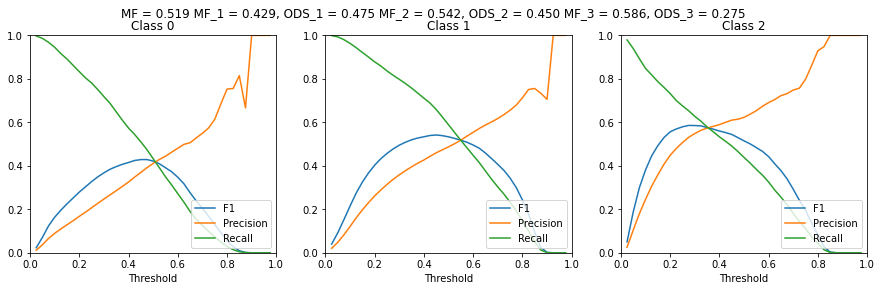

In [15]:
if not TRAIN_MODEL:
    step_width = 0.025
    threshold_range = [0.025, 0.975]
    threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_real_edge_threshold_{:.1f}.svg".format(0))
    threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, ds=test_real_ds, 
                                                                   num_classes = NUM_CLASSES,
                                                                   threshold_array=threshold_array, 
                                                                   threshold_edge_width=0, save=SAVE, 
                                                                   path=path_metrics_evaluation_plot)

## Visual Results

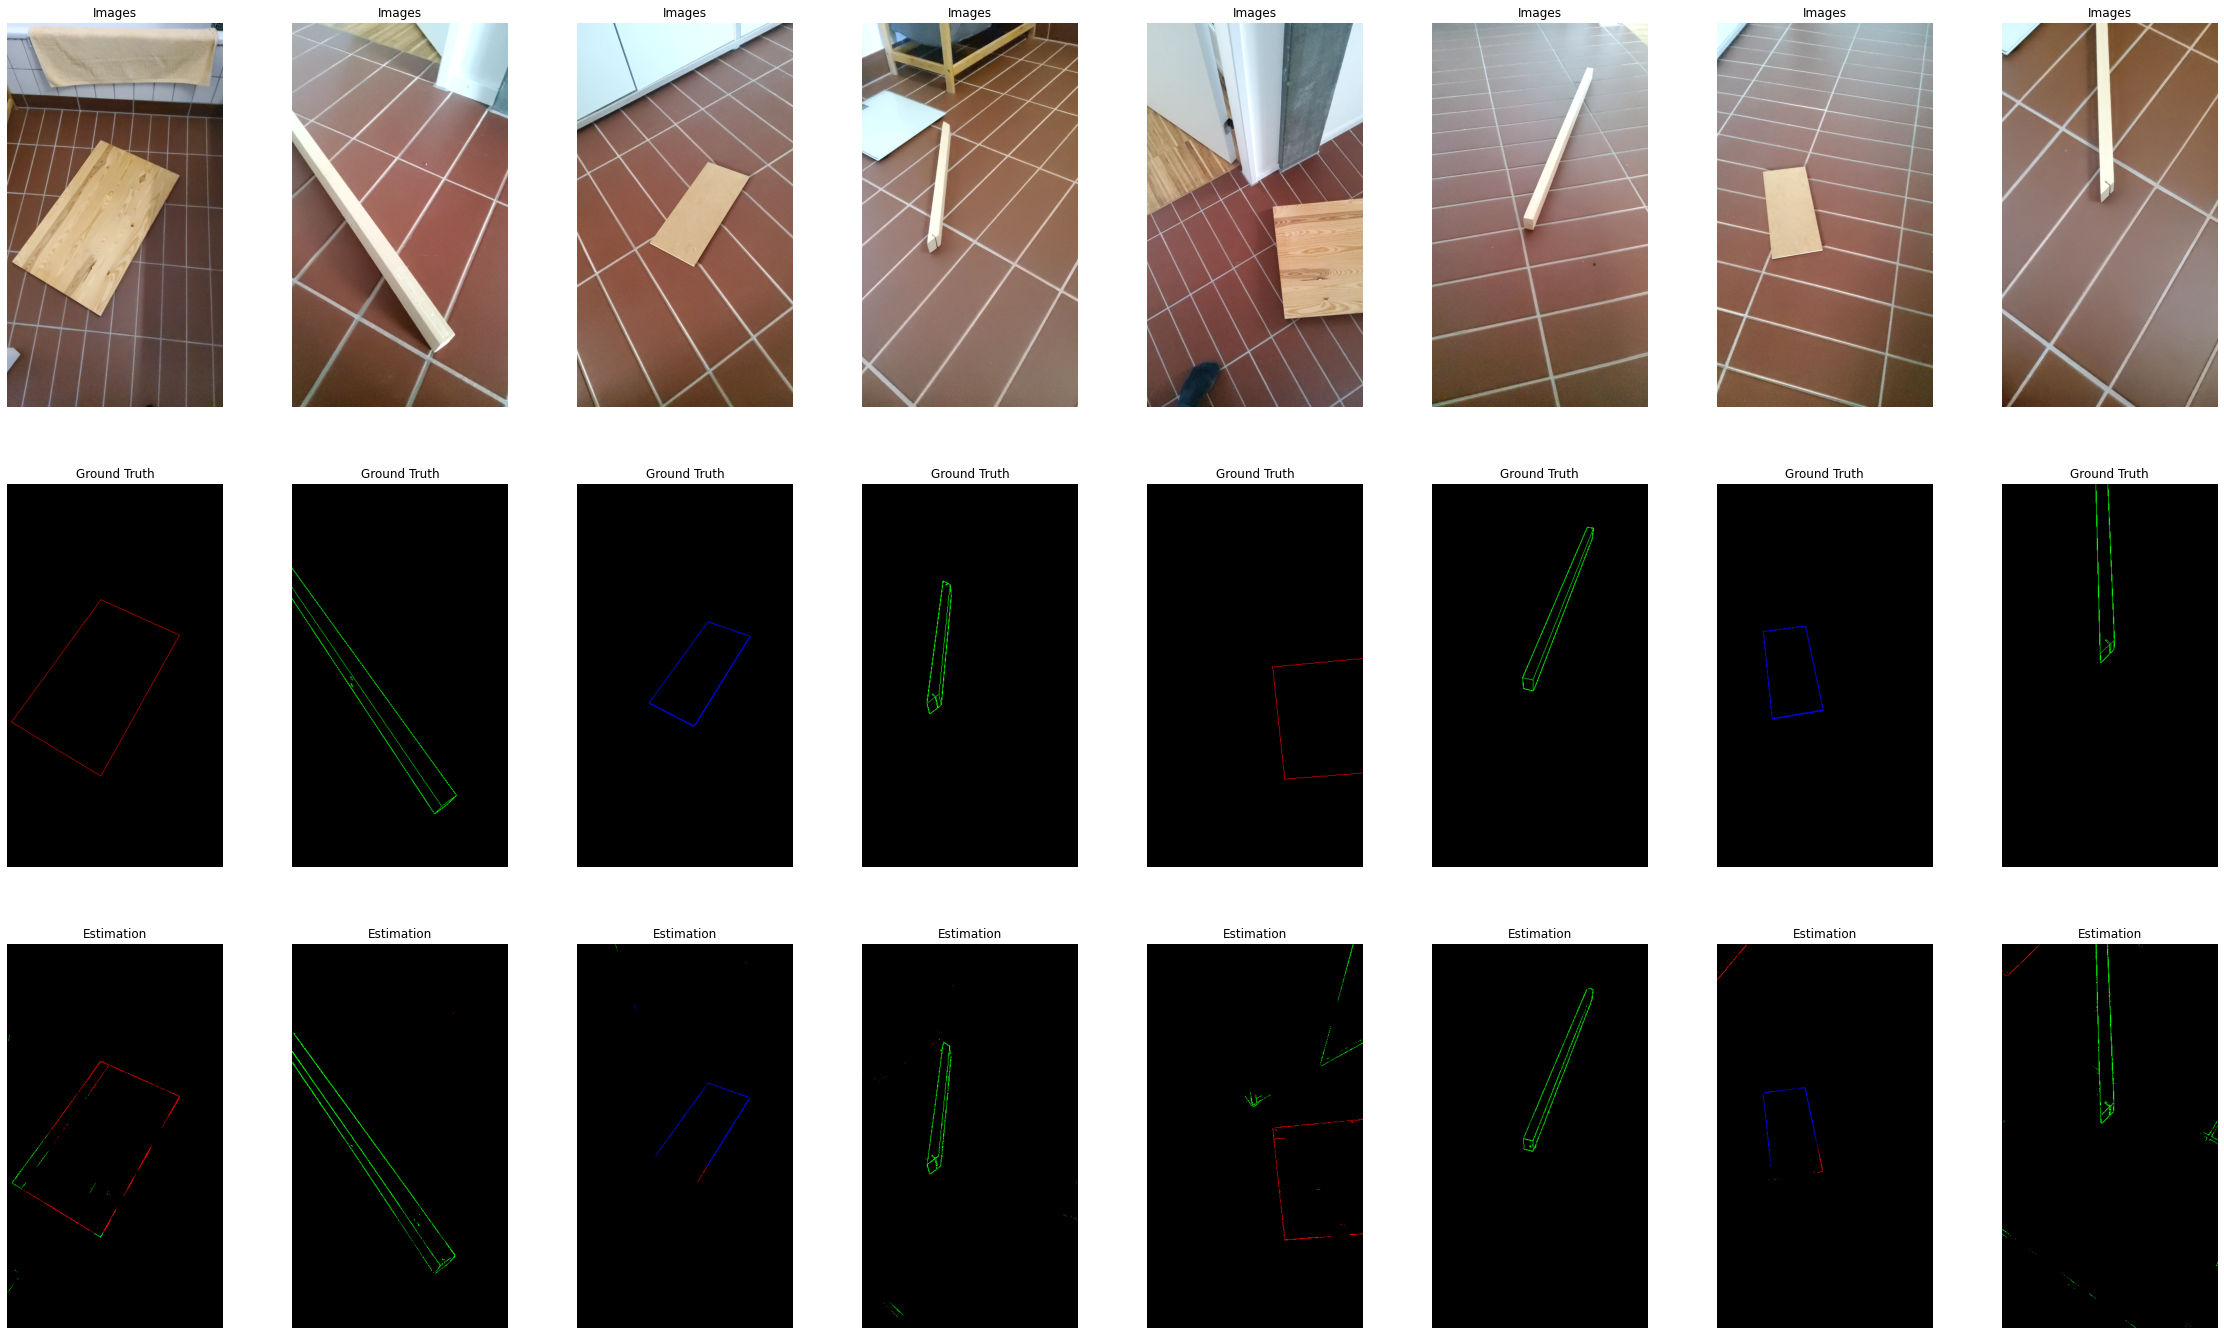

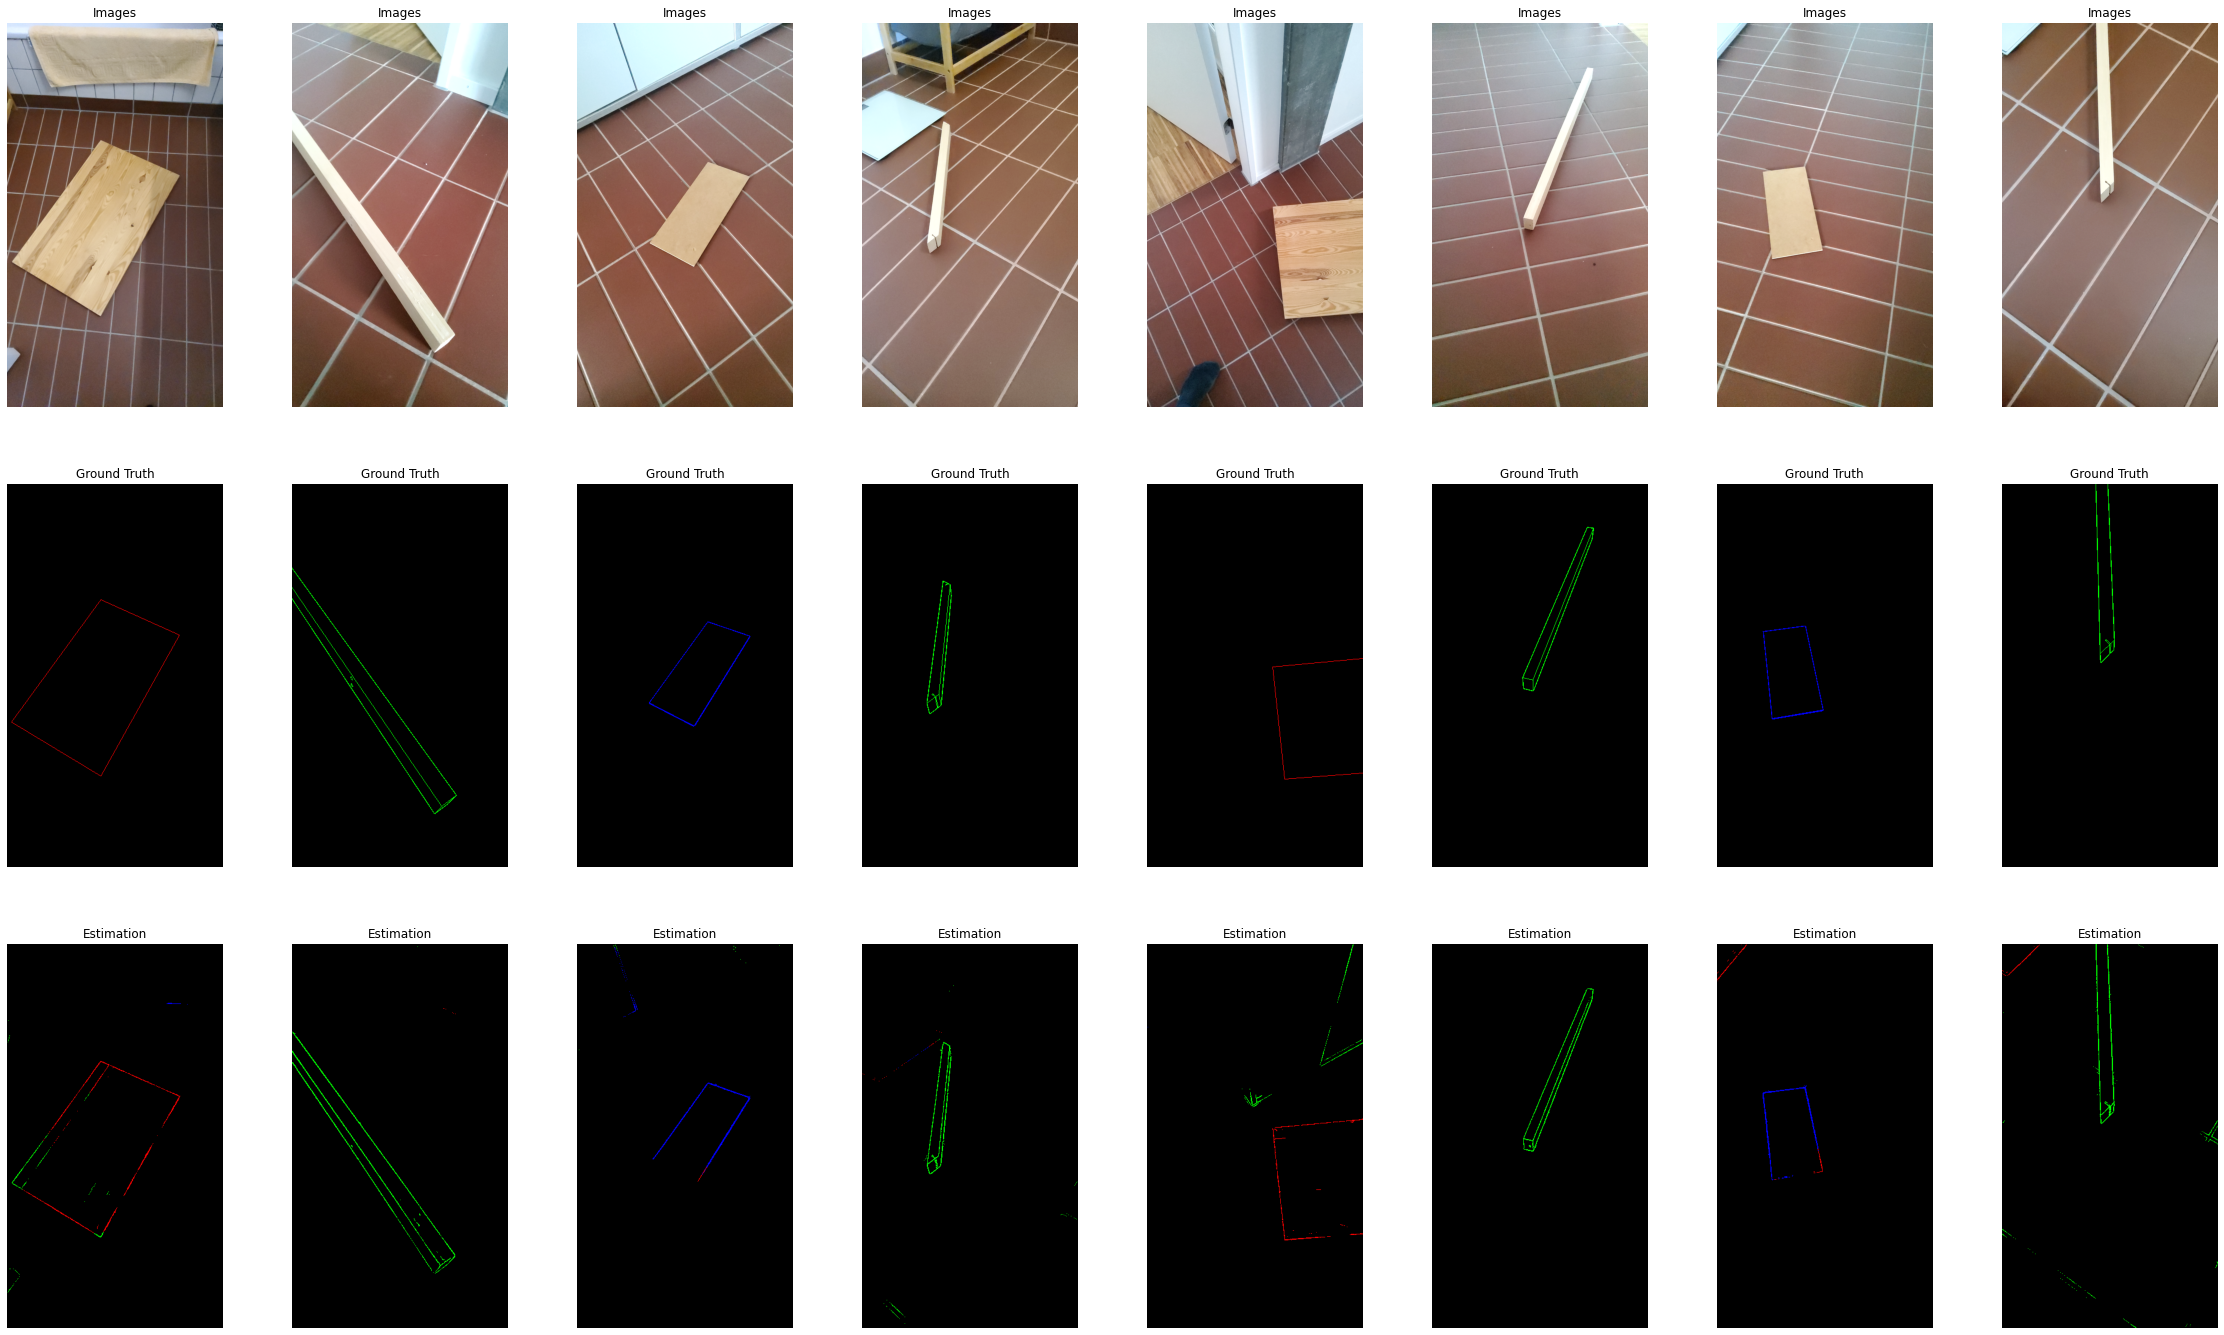

In [16]:
if not TRAIN_MODEL:
    for img, label in test_real_ds.take(1):
        img, label = img, label


    threshold = 0.5

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions, threshold=threshold)

    path = os.path.join(paths["FIGURES"],"images_test_real_threshold_{:.2f}".format(threshold))
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

    threshold = threshold_f1_max

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions, threshold=threshold)

    path = os.path.join(paths["FIGURES"],"images_test_real_threshold_ods")
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

# Save Model

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

if SAVE:
    model.save(paths["MODEL"])
    
    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                      "F1Edges": metrics.F1Edges,
                      "<lambda>":loss}
    
    model = tf.keras.models.load_model(paths["MODEL"], custom_objects=custom_objects)

2022-06-07 22:13:57.908910: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/SGED_FOCAL_LOSS_0.5_g2_a2/assets
